## 네이버 API를 호출하여 검색하는 샘플

In [25]:
# !pip install bs4
# !pip install selenium
# !pip install webdriver_manager
!pip install pillow
!pip install pytesseract


## URL에서 화면 추출
get_content_from_url


In [17]:

# 검색 결과에서 링크 추출하고 내용 가져오기
from bs4 import BeautifulSoup

# type = 1:ghost driver, 2:chrome driver
def get_content_from_url(type: int, url: str) -> str:
    """URL에서 본문 내용을 추출합니다 (iframe 포함)"""
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    
    try:
        if type == 1:
            # Selenium 설정
            chrome_options = Options()
            chrome_options.add_argument('--headless')  # 브라우저 창 숨기기
            chrome_options.add_argument('--no-sandbox')
            chrome_options.add_argument('--disable-dev-shm-usage')
            driver = webdriver.Chrome(options=chrome_options)
        elif type == 2:
            driver = webdriver.Chrome()  # 실제 크롬 브라우저를 띄우기 위해 옵션 제거
        else:
            raise ValueError("유효하지 않은 유형입니다. ghost driver를 사용하려면 1을, chrome driver를 사용하려면 2를 입력하세요.")
    
        driver.get(url)
        
        # iframe이 로드될 때까지 잠시 대기
        WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located)
        
        # 모든 iframe으로 전환하면서 내용 수집
        content = []
        
        # 메인 페이지 내용 추출
        main_content = driver.page_source
        soup = BeautifulSoup(main_content, 'html.parser')
        
        print(main_content)
        
        # 불필요한 태그 제거
        for tag in soup(['script', 'style']):
            tag.decompose()
            
        content.append(soup.get_text())
        
        # iframe 내용 추출
        iframes = driver.find_elements('tag name', 'iframe')
        for iframe in iframes:
            try:
                driver.switch_to.frame(iframe)
                iframe_content = driver.page_source
                iframe_soup = BeautifulSoup(iframe_content, 'html.parser')
                
                for tag in iframe_soup(['script', 'style']):
                    tag.decompose()
                    
                content.append(iframe_soup.get_text())
                driver.switch_to.default_content()
            except:
                continue
                
        driver.quit()
        
        # 전체 내용 정리
        text = '\n'.join(content)
        lines = [line.strip() for line in text.splitlines() if line.strip()]
        
        # 텍스트 파일로 저장
        text_content = '\n'.join(lines)
        
        # URL에서 파일명 생성 (마지막 부분 추출)
        from datetime import datetime
        
        # 도메인 주소 앞부분 추출
        domain = url.split('/')[2].split('.')[0]
        
        # 현재 일자 시분초 생성
        current_time = datetime.now().strftime("%Y%m%d%H%M%S")
        
        # 파일명 생성
        filename = f"{domain}_{current_time}.html"
            
        # 파일 저장
        with open(f"example/{filename}", 'w', encoding='utf-8') as f:
            f.write(text_content)
            
        print(f"파일 저장 완료: example/{filename}")
        return text_content
        
    except Exception as e:
        print(f"URL 접속 중 오류 발생: {url}")
        print(f"오류 내용: {str(e)}")
        return ""


# 네이버 API 호출

In [5]:
# 네이버 API를 호출하여 검색하는 샘플
import requests

def naver_search(query):
    client_id = "8IZ0G5iuDP3RfxlVCEX7"
    client_secret = "kj_oKc7ROo"
    url = "https://openapi.naver.com/v1/search/webkr.json"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret,
    }
    params = {"query": query, "display": 10}  # 최대 10개의 결과 표시
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        return response.json()  # JSON 형식의 검색 결과
    else:
        return response.status_code


# 검색 예시
results = naver_search("13인치 노트북 추천")

# 검색 결과의 각 항목에서 링크 추출하고 내용 가져오기
contents = []
for item in results['items']:
    url = item['link']
    title = item['title']
    print(f"\n제목: {BeautifulSoup(title, 'html.parser').get_text()}")
    print(f"URL: {url}")
    
    content = get_content_from_url(2, url)
    if content:
        contents.append({
            'title': BeautifulSoup(title, 'html.parser').get_text(),
            'url': url,
            'content': content
        })
        print(f"내용 길이: {len(content)} 글자")
    else: 
        print("내용을 가져오지 못했습니다")

print(f"\n총 {len(contents)}개의 페이지에서 내용을 추출했습니다.")


## 쿠팡 페이지 추출

<html lang="ko-KR"><!--<![endif]--><head><style class="vjs-styles-defaults">
      .video-js {
        width: 300px;
        height: 150px;
      }

      .vjs-fluid {
        padding-top: 56.25%
      }
    </style><img style="display:none;" width="1" height="1" attributionsrc="https://measurement-api.criteo.com/conversiontracking?a=3119&amp;v=5.11.0&amp;p0=e%3Dexd%26site_type%3Dd&amp;p1=e%3Dvp%26p%3D6947011669&amp;p2=e%3Ddis&amp;adce=1&amp;bundle=O23hZF9LVkxCY3VrVyUyRk94RUMxdjFNMlEydnI2MWdLcTJZU1J1V1pjTlN5bkVEbjNQY3ZGZGdISzBnZ0dBMmxROEtvaHFFTHBGblQlMkZPNm0lMkJUVGxzaDJBOWc0ekp1WTJvSU0yY2VEUTdNV1lwbmNLdWg4JTJCJTJCUVFkYjc0Z2hGQkFsSGhESml3S210TFpGUFRQaXp3UkZ1YVVaWU53JTNEJTNE&amp;tld=coupang.com&amp;ful=680&amp;fu=https%3A%2F%2Fwww.coupang.com%2Fvp%2Fproducts%2F6947011669%3FitemId%3D16865463253%26src%3D1139000%26spec%3D10799999%26addtag%3D400%26ctag%3D6947011669%26lptag%3DAF8428941%26itime%3D20241212165338%26pageType%3DPRODUCT%26pageValue%3D6947011669%26wPcid%3D17339900183500167860524%26w
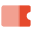
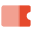
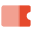
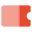

In [18]:
coupang_url = "https://link.coupang.com/a/b4z0ir"
content = get_content_from_url(2, coupang_url)

## 이미지 추출하기


In [19]:
from bs4 import BeautifulSoup
import re

# Function to check if an image is likely part of the content and not an ad/banner
def is_content_image(img_url):
    # Define patterns to exclude ads or banners
    exclude_patterns = [
        r"ad", r"banner", r"promo", r"tracking", r"criteo", r"facebook", r"google",
        r"doubleclick", r"thumbnail[0-9]+\.coupangcdn\.com"
    ]
    # If any exclude pattern matches the image URL, it's not content
    return not any(re.search(pattern, img_url) for pattern in exclude_patterns)

# Function to extract content-related images from HTML
def extract_content_images(file_path):
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')

    # Find all <img> tags
    img_tags = soup.find_all('img')

    # Filter and extract valid content image URLs
    content_images = []
    for img in img_tags:
        img_url = img.get('src') or img.get('data-src')  # Consider src or data-src attributes
        if img_url and is_content_image(img_url):
            content_images.append(img_url)

    return content_images

# Example usage
file_path = 'example/coupang_111.html'
content_images = extract_content_images(file_path)

# Output the extracted image URLs
for img_url in content_images:
    print(img_url)


//image7.coupangcdn.com/image/coupang/common/logo_coupang_w350.png
//image7.coupangcdn.com/image/coupang/common/coupang_play_logo_2024@3x.png
//image10.coupangcdn.com/image/coupang/rds/logo/xxhdpi/logo_rocket_symbol_large.png
//image10.coupangcdn.com/image/coupang/home/icons/Christmas/2023_christmas_B.png
//image6.coupangcdn.com/image/coupang/common/logoBizonlyBrown.png
//image6.coupangcdn.com/image/coupang/home/icons/Overseas.png
//image7.coupangcdn.com/image/coupang/home/icons/omp_pc_shortcut_20240510.png
//image10.coupangcdn.com/image/coupang/home/icons/RETURNED_MARKET_B@2x.png
//image6.coupangcdn.com/image/coupang/home/icons/travel/web_travel.png
//image7.coupangcdn.com/image/coupang/home/icons/sell_on_coupang_pc.png
https://image7.coupangcdn.com/image/coupang/rds/logo/hdpi/logo_rocket_small.png
https://image7.coupangcdn.com/image/coupang/rds/logo/hdpi/logo_rocket_small.png
//img1a.coupangcdn.com/image/sdp/option-table/icon_tabs_btn-right.png
https://image7.coupangcdn.com/image/cou

## 이미지 읽기

In [27]:
from bs4 import BeautifulSoup
import re
import requests
from PIL import Image
from io import BytesIO
import pytesseract

# Function to check if an image is likely part of the content and not an ad/banner
def is_content_image(img_url):
    # Define patterns to exclude ads or banners
    exclude_patterns = [
        r"ad", r"banner", r"promo", r"tracking", r"criteo", r"facebook", r"google",
        r"doubleclick", r"thumbnail[0-9]+\.coupangcdn\.com"
    ]
    # If any exclude pattern matches the image URL, it's not content
    return not any(re.search(pattern, img_url) for pattern in exclude_patterns)

# Function to extract content-related images from HTML
def extract_content_images(file_path):
    # Read the HTML file
    with open(file_path, 'r', encoding='utf-8') as file:
        soup = BeautifulSoup(file, 'html.parser')

    # Find all <img> tags
    img_tags = soup.find_all('img')

    # Filter and extract valid content image URLs
    content_images = []
    for img in img_tags:
        img_url = img.get('src') or img.get('data-src')  # Consider src or data-src attributes
        if img_url and is_content_image(img_url):
            content_images.append(img_url)

    return content_images


# Example usage
file_path = 'example/coupang_111.html'
content_images = extract_content_images(file_path)

print("Extracted Image URLs:")
for img_url in content_images:
    print(img_url)

# 이미지 다운로드
for img_url in content_images:
    try:
        # Ensure the URL is complete
        if img_url.startswith("//"):
            img_url = "https:" + img_url

        # Download the image
        response = requests.get(img_url)
        if response.status_code == 200:
            with open(img_url.split("/")[-1], 'wb') as f:
                f.write(response.content)
            print(f"Image downloaded: {img_url}")
        else:
            print(f"Failed to download image: {img_url}")
    except Exception as e:
        print(f"Error downloading image {img_url}: {e}")


Extracted Image URLs:
//image7.coupangcdn.com/image/coupang/common/logo_coupang_w350.png
//image7.coupangcdn.com/image/coupang/common/coupang_play_logo_2024@3x.png
//image10.coupangcdn.com/image/coupang/rds/logo/xxhdpi/logo_rocket_symbol_large.png
//image10.coupangcdn.com/image/coupang/home/icons/Christmas/2023_christmas_B.png
//image6.coupangcdn.com/image/coupang/common/logoBizonlyBrown.png
//image6.coupangcdn.com/image/coupang/home/icons/Overseas.png
//image7.coupangcdn.com/image/coupang/home/icons/omp_pc_shortcut_20240510.png
//image10.coupangcdn.com/image/coupang/home/icons/RETURNED_MARKET_B@2x.png
//image6.coupangcdn.com/image/coupang/home/icons/travel/web_travel.png
//image7.coupangcdn.com/image/coupang/home/icons/sell_on_coupang_pc.png
https://image7.coupangcdn.com/image/coupang/rds/logo/hdpi/logo_rocket_small.png
https://image7.coupangcdn.com/image/coupang/rds/logo/hdpi/logo_rocket_small.png
//img1a.coupangcdn.com/image/sdp/option-table/icon_tabs_btn-right.png
https://image7.co

In [29]:
# Function to download and analyze images
def analyze_images(image_urls):
    for img_url in image_urls:
        try:
            # Ensure the URL is complete
            if img_url.startswith("//"):
                img_url = "https:" + img_url

            # Download the image
            response = requests.get(img_url)
            if response.status_code == 200:
                image = Image.open(BytesIO(response.content))

                # Analyze the image using OCR
                text = pytesseract.image_to_string(image, lang='eng')
                print(f"Image URL: {img_url}\nExtracted Text: {text}\n")
            else:
                print(f"Failed to download image: {img_url}")
        except Exception as e:
            print(f"Error processing image {img_url}: {e}")

import os

def analyze_images_in_folder(folder_path):
    # 폴더 내의 모든 파일을 순회
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                # 이미지 파일 열기
                with open(file_path, 'rb') as f:
                    image = Image.open(f)

                    # OCR을 사용하여 이미지에서 텍스트 추출
                    text = pytesseract.image_to_string(image, lang='eng')
                    print(f"File: {file_path}\nExtracted Text: {text}\n")
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")


# url 이미지 분석
print("\nAnalyzing Images:")
# analyze_images(content_images)

# 폴더내 이미지 분석
analyze_images_in_folder("example/image")



Analyzing Images:
File: example/image/123.jpg
Extracted Text: at
=

HI: Pp

A-VIC SPORTS
mols AEA

AMES AFWFE

AS bbe} z2tHt
SE visi

< Ventilation — Soffit

- Sieh
_ WARM KEEPING AND TEMPERATURE LOCKING

~ ADIDAS
HS Zsa! Sey

AVIC SPORTS
oyojsy AA

AS S01! AlOk
MASSA 3D BA Al

LSS s14Stota, AOE F SH0cs

a

= Alztoro4
BESO] SSLICt.

3, 2S 4S betSctut

BMI: SUBS WZ dietSAtwtS SIH

3 CAS 43S Hatori

Ol AS MeonAS ict.

‘0
10
ae
Bro
0 9 ie

o>
HHH

Clel=

is SH71s= AB I|24M=
OMI Liza THst Sey

AIOIE! SBF OFLI2t
Crefst AZA, OLEA SSH
ast 4 Qe
A GOS Ser acfacd/2
Bets 2rur

PE - “s | PRODUCT PARAMETERS
i— a —) AND DIMENSIONS
ll

42cm

ABS: MOM 2B 20S Sst SarsAlA base ASI
4M: BrllAH, AB, Wi
AOIZ: $1 AtOlZ OMIA BA
MB: AHMO(DS), 2H0l, S4(Tes), S44
4S HalBall: 53-63cm
SBlel/BMA: (=)BzOlAHA

Hol Bea |

A-VIC SPORTS

M14] AA




# 이미지 인식 결과

tesseractocr 모듈은 성능이 너무 안좋다.

아래 내용을 참고하자

### 1. **Google Cloud Vision API**
   - **특징**:
     - 고성능 OCR로 한국어를 포함한 여러 언어를 정확히 인식.
     - 이미지를 업로드하면 텍스트를 추출해주는 클라우드 기반 서비스.
     - 문서와 이미지 모두 잘 처리하며 다양한 파일 포맷 지원.
   - **요금**: 사용량에 따라 종량제로 요금 부과.
   - **장점**:
     - 고정밀 OCR.
     - OCR뿐만 아니라 이미지 분류, 객체 감지 기능 제공.
   - **웹사이트**: [Google Cloud Vision](https://cloud.google.com/vision)

---

### 2. **AWS Textract**
   - **특징**:
     - Amazon Web Services에서 제공하는 문서 분석 도구.
     - 스캔된 문서나 이미지를 분석하여 텍스트 추출.
   - **요금**: 사용량에 따라 종량제.
   - **장점**:
     - 텍스트 인식뿐만 아니라 테이블과 양식 데이터를 구조적으로 추출 가능.
     - 한국어 지원.
   - **웹사이트**: [AWS Textract](https://aws.amazon.com/textract/)

---

### 3. **ABBYY FineReader Server**
   - **특징**:
     - 한국어 OCR 인식에서 뛰어난 성능을 제공하는 데스크톱 및 서버 소프트웨어.
     - 대량 문서 처리에 적합.
   - **요금**: 라이선스 기반, 사용자 수 및 기능에 따라 가격 결정.
   - **장점**:
     - 매우 정확한 텍스트 인식.
     - 이미지 전처리 도구 제공.
   - **웹사이트**: [ABBYY FineReader](https://www.abbyy.com/)

---

### 4. **Naver CLOVA OCR**
   - **특징**:
     - 네이버에서 제공하는 한국어 특화 OCR 서비스.
     - 한국어 인식에 최적화되어 있으며, 다양한 비즈니스 솔루션에 통합 가능.
   - **요금**: 종량제.
   - **장점**:
     - 한국어 문서에 강점.
     - API를 통해 쉽게 통합 가능.
   - **웹사이트**: [Naver CLOVA OCR](https://www.ncloud.com/product/aiService/ocr)

---

### 5. **Azure Cognitive Services - Computer Vision**
   - **특징**:
     - Microsoft Azure의 OCR API.
     - 다국어 OCR 지원(한국어 포함).
   - **요금**: 종량제.
   - **장점**:
     - 정확도 높은 OCR.
     - 다른 Azure AI 서비스와 통합 가능.
   - **웹사이트**: [Azure Computer Vision](https://azure.microsoft.com/en-us/services/cognitive-services/computer-vision/)

---

### 추천 요약
- **정확한 OCR을 원한다면:** Google Cloud Vision 또는 ABBYY FineReader.
- **대량 처리와 데이터 분석까지 필요하다면:** AWS Textract 또는 Azure Cognitive Services.
- **한국어 특화 OCR을 원한다면:** Naver CLOVA OCR.




비용 비교 표를 작성하여 공유했습니다. 필요에 따라 더 자세한 정보가 필요하거나 추가적인 조정을 원하시면 알려주세요!